**目的****

このノートブックは、ダミーのテキストデータ（レビュー文）＋数値データ（年齢・所得・予算・購入点数・サイト滞在時間・割引利用率）を生成し、消費者志向（Price‑Sensitive / Eco‑Conscious / Brand‑Loyal / Convenience‑Seeker）をマルチモーダル分類する、無料・登録不要のColab用デモです。外部APIや有料サービスは使いません。

**構成**

テキスト特徴量: TfidfVectorizer（ユニグラム＋バイグラム）

数値特徴量: StandardScaler（標準化）

特徴結合: ColumnTransformer（テキスト＋数値を一つの特徴行列へ）

分類器: LogisticRegression (multinomial, solver='saga')

評価: 5分割の層化CV（Accuracy & Macro‑F1）、テストセット評価、混同行列

説明可能性: クラスごとの上位TF‑IDF語、数値重み（係数）を出力

成果物: 生成データ（CSV）と学習パイプライン（pickle）を保存

---

**Purpose**

This Colab notebook generates dummy text + numeric data and trains a simple, explainable multimodal classifier to predict consumer orientation (Price‑Sensitive / Eco‑Conscious / Brand‑Loyal / Convenience‑Seeker). It’s free, API‑free, and fully reproducible.

**Structure**

Text features: TfidfVectorizer (uni/bi‑grams)

Numeric features: StandardScaler

Feature fusion: ColumnTransformer (concatenate text + numeric)

Classifier: LogisticRegression (multinomial, saga)

Evaluation: Stratified 5‑fold CV (Accuracy & Macro‑F1), test set metrics, confusion matrix

Explainability: Top TF‑IDF terms per class + numeric feature weights (coefficients)

Artifacts: Saves synthetic dataset (CSV) and trained pipeline (pickle)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/test/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/test


In [ ]:
#@title Imports & setup (run this first)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
np.random.seed(42)

print('Environment ready. numpy:', np.__version__, 'pandas:', pd.__version__)


Environment ready. numpy: 2.0.2 pandas: 2.2.2


## 1) Create dummy text + numeric data
We craft synthetic samples with text phrases that correlate with orientations and numeric features offering additional signal (e.g., age, income, discount usage). This is **for demonstration purposes only**.


In [ ]:
#@title Generate synthetic dataset
n_per_class = 300  # you can increase for larger dataset

labels = ['Price-Sensitive', 'Eco-Conscious', 'Brand-Loyal', 'Convenience-Seeker']

text_templates = {
    'Price-Sensitive': [
        'I always look for discounts and lowest prices',
        'Coupons and sales determine my purchases',
        'Budget is my top priority when shopping',
        'I compare prices across stores before buying',
        'Best deals win my attention'
    ],
    'Eco-Conscious': [
        'I prefer sustainable and eco-friendly products',
        'Environmentally responsible brands matter to me',
        'I avoid plastic packaging and non-recyclables',
        'I choose organic and fair-trade options',
        'Carbon footprint influences my choices'
    ],
    'Brand-Loyal': [
        'I stick to trusted brands I have used for years',
        'Brand reputation is essential to me',
        'I follow my favorite brands closely',
        'I buy from the same brand even if price is higher',
        'I value consistent quality from known brands'
    ],
    'Convenience-Seeker': [
        'I want quick delivery and easy checkout',
        'I prefer one-click purchases and fast service',
        'Time-saving is more important than price',
        'I choose stores with hassle-free returns',
        'I value convenience and availability'
    ],
}

# Helper to create numeric features aligned with orientation tendencies

def gen_numeric(label, size):
    # Base distributions per class to inject signal (still overlapping)
    if label == 'Price-Sensitive':
        age = np.random.normal(35, 10, size)
        income = np.random.normal(38000, 8000, size)
        budget = np.random.normal(150, 40, size)
        items = np.random.poisson(3, size)
        time_on_site = np.random.normal(6, 2, size)  # compares more
        discount_rate = np.clip(np.random.normal(0.6, 0.15, size), 0, 1)
    elif label == 'Eco-Conscious':
        age = np.random.normal(32, 9, size)
        income = np.random.normal(52000, 12000, size)
        budget = np.random.normal(220, 50, size)
        items = np.random.poisson(2, size)
        time_on_site = np.random.normal(5, 2, size)
        discount_rate = np.clip(np.random.normal(0.3, 0.15, size), 0, 1)
    elif label == 'Brand-Loyal':
        age = np.random.normal(40, 12, size)
        income = np.random.normal(60000, 15000, size)
        budget = np.random.normal(300, 70, size)
        items = np.random.poisson(2, size)
        time_on_site = np.random.normal(4.5, 1.5, size)
        discount_rate = np.clip(np.random.normal(0.25, 0.1, size), 0, 1)
    else:  # Convenience-Seeker
        age = np.random.normal(30, 8, size)
        income = np.random.normal(45000, 10000, size)
        budget = np.random.normal(200, 60, size)
        items = np.random.poisson(4, size)
        time_on_site = np.random.normal(3.5, 1.2, size)  # fast decisions
        discount_rate = np.clip(np.random.normal(0.35, 0.15, size), 0, 1)

    return {
        'age': age,
        'income': income,
        'budget': budget,
        'num_items_purchased': items,
        'time_on_site_min': time_on_site,
        'discount_usage_rate': discount_rate,
    }

rows = []
for label in labels:
    numerics = gen_numeric(label, n_per_class)
    texts = np.random.choice(text_templates[label], size=n_per_class)
    for i in range(n_per_class):
        rows.append({
            'orientation': label,
            'review_text': texts[i],
            'age': float(numerics['age'][i]),
            'income': float(numerics['income'][i]),
            'budget': float(numerics['budget'][i]),
            'num_items_purchased': int(numerics['num_items_purchased'][i]),
            'time_on_site_min': float(numerics['time_on_site_min'][i]),
            'discount_usage_rate': float(numerics['discount_usage_rate'][i]),
        })

df = pd.DataFrame(rows)
print('Dataset shape:', df.shape)
print(df.head())

# Save CSV for reuse
csv_path = 'synthetic_multimodal_consumer_orientation.csv'
df.to_csv(csv_path, index=False)
print('Saved CSV ->', csv_path)


Dataset shape: (1200, 8)
       orientation                                    review_text        age  \
0  Price-Sensitive  I always look for discounts and lowest prices  39.967142   
1  Price-Sensitive                    Best deals win my attention  33.617357   
2  Price-Sensitive        Budget is my top priority when shopping  41.476885   
3  Price-Sensitive  I always look for discounts and lowest prices  50.230299   
4  Price-Sensitive  I always look for discounts and lowest prices  32.658466   

         income      budget  num_items_purchased  time_on_site_min  \
0  31368.039913  180.279545                    4          2.605805   
1  33518.551678  113.113387                    4          4.708861   
2  43978.348841  184.784237                    3         11.356220   
3  42882.962123  204.225514                    6          5.028698   
4  37832.787248  166.537396                    2          2.081220   

   discount_usage_rate  
0             0.658990  
1             0.811949 

## 2) Split into train/test
We use a stratified split to keep class balance in both sets.


In [ ]:
#@title Train/test split
X = df.drop(columns=['orientation'])
y = df['orientation']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('Train:', X_train.shape, '| Test:', X_test.shape)


Train: (960, 7) | Test: (240, 7)


## 3) Build a multimodal pipeline (text + numeric)
We combine **TF-IDF for text** and **scaling for numeric** in a single `ColumnTransformer`, then train a multinomial Logistic Regression.


In [ ]:
#@title Define and train the pipeline
text_col = 'review_text'
num_cols = ['age','income','budget','num_items_purchased','time_on_site_min','discount_usage_rate']

preprocess = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(ngram_range=(1,2), stop_words='english', min_df=1), text_col),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='drop'
)

clf = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    max_iter=500,
    random_state=42
)

pipe = Pipeline(steps=[('prep', preprocess), ('clf', clf)])
pipe.fit(X_train, y_train)

print('Pipeline trained.')


Pipeline trained.


## 4) Cross-validation (CV)
We estimate generalization with stratified 5-fold CV on the training set.


In [ ]:
#@title Cross-validation scores (accuracy & macro-F1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='accuracy')
f1_scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='f1_macro')

print(f"CV Accuracy: {acc_scores.mean():.3f} ± {acc_scores.std():.3f}")
print(f"CV Macro-F1: {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")


CV Accuracy: 0.997 ± 0.004
CV Macro-F1: 0.997 ± 0.004


## 5) Evaluate on the test set
We report accuracy, macro-F1, a classification report, and visualize the confusion matrix.


Test Accuracy: 0.996
Test Macro-F1: 0.996

Classification Report:



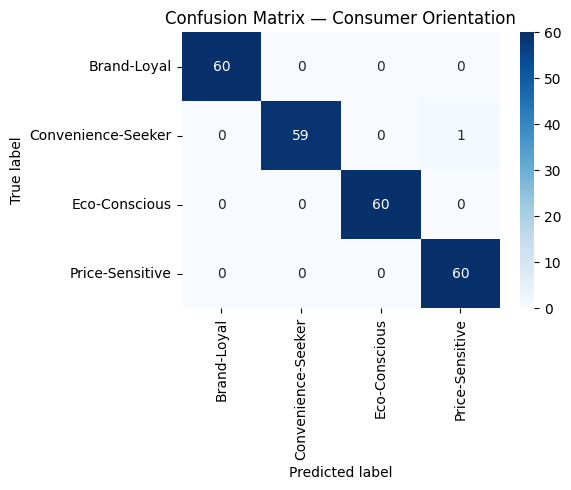

In [ ]:
#@title Test metrics & confusion matrix
# Predict
y_pred = pipe.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
macrof1 = f1_score(y_test, y_pred, average='macro')
print(f'Test Accuracy: {acc:.3f}')
print(f'Test Macro-F1: {macrof1:.3f}')
print('\nClassification Report:\n')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=pipe.classes_, yticklabels=pipe.classes_, ax=ax)
ax.set_title('Confusion Matrix — Consumer Orientation')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.tight_layout()
plt.show()

## 6) Feature insights (text & numeric)
We inspect model coefficients to understand which features (words/phrases and numeric variables) influence each class.

> Note: Coefficients are from the trained multinomial Logistic Regression. Positive values increase the likelihood of the class.


In [ ]:
#@title Show top TF-IDF terms per class & numeric feature weights
# Get feature names from the ColumnTransformer
ct = pipe.named_steps['prep']
feature_names = ct.get_feature_names_out()

# Coefficients: shape (n_classes, n_features)
coef = pipe.named_steps['clf'].coef_
classes = pipe.named_steps['clf'].classes_

# Split feature names: text vs numeric
text_mask = np.array([name.startswith('text__') for name in feature_names])
num_mask = np.array([name.startswith('num__') for name in feature_names])

text_features = feature_names[text_mask]
num_features = feature_names[num_mask]

text_indices = np.where(text_mask)[0]
num_indices = np.where(num_mask)[0]

# For each class, show top 10 positive text terms
top_k = 10
for i, cls in enumerate(classes):
    cls_coef = coef[i]
    text_coef = cls_coef[text_indices]
    top_idx = np.argsort(text_coef)[-top_k:][::-1]
    top_terms = [(text_features[j].replace('text__',''), float(text_coef[j])) for j in top_idx]
    print(f"\nTop {top_k} TF-IDF terms for class: {cls}")
    for term, weight in top_terms:
        print(f"  {term:35s}  weight: {weight:.3f}")

# Numeric feature weights per class
print('\nNumeric feature weights per class:')
for i, cls in enumerate(classes):
    cls_coef = coef[i]
    num_coef = cls_coef[num_indices]
    print(f"\nClass: {cls}")
    for name, w in zip(num_features, num_coef):
        print(f"  {name.replace('num__',''):25s} weight: {w:.3f}")


Top 10 TF-IDF terms for class: Brand-Loyal
  brand                                weight: 1.400
  brands                               weight: 1.236
  favorite                             weight: 0.978
  brands closely                       weight: 0.978
  closely                              weight: 0.978
  follow                               weight: 0.978
  favorite brands                      weight: 0.978
  follow favorite                      weight: 0.978
  brand reputation                     weight: 0.901
  reputation                           weight: 0.901

Top 10 TF-IDF terms for class: Convenience-Seeker
  value convenience                    weight: 1.137
  availability                         weight: 1.137
  convenience                          weight: 1.137
  convenience availability             weight: 1.137
  saving important                     weight: 0.996
  time                                 weight: 0.996
  important price                      weight: 0.996
  ti

## 7) Inference demo
Try a few samples with text + numbers to see predictions.


In [ ]:
#@title Predict on new samples
samples = pd.DataFrame([
    {
        'review_text': 'I always look for discounts and lowest prices',
        'age': 34, 'income': 40000, 'budget': 160, 'num_items_purchased': 3,
        'time_on_site_min': 6.5, 'discount_usage_rate': 0.7
    },
    {
        'review_text': 'I prefer sustainable and eco-friendly products',
        'age': 29, 'income': 55000, 'budget': 240, 'num_items_purchased': 2,
        'time_on_site_min': 4.8, 'discount_usage_rate': 0.2
    },
    {
        'review_text': 'I want quick delivery and easy checkout',
        'age': 31, 'income': 47000, 'budget': 210, 'num_items_purchased': 4,
        'time_on_site_min': 3.2, 'discount_usage_rate': 0.35
    },
    {
        'review_text': 'I buy from the same brand even if price is higher',
        'age': 41, 'income': 62000, 'budget': 320, 'num_items_purchased': 2,
        'time_on_site_min': 4.0, 'discount_usage_rate': 0.2
    },
])

preds = pipe.predict(samples)
probs = pipe.predict_proba(samples)

for i, row in samples.iterrows():
    print(f"Sample {i+1}: Predicted = {preds[i]}  | Probabilities = {dict(zip(pipe.classes_, probs[i].round(3)))}")


Sample 1: Predicted = Price-Sensitive  | Probabilities = {'Brand-Loyal': np.float64(0.001), 'Convenience-Seeker': np.float64(0.003), 'Eco-Conscious': np.float64(0.003), 'Price-Sensitive': np.float64(0.993)}
Sample 2: Predicted = Eco-Conscious  | Probabilities = {'Brand-Loyal': np.float64(0.021), 'Convenience-Seeker': np.float64(0.011), 'Eco-Conscious': np.float64(0.967), 'Price-Sensitive': np.float64(0.001)}
Sample 3: Predicted = Convenience-Seeker  | Probabilities = {'Brand-Loyal': np.float64(0.01), 'Convenience-Seeker': np.float64(0.97), 'Eco-Conscious': np.float64(0.015), 'Price-Sensitive': np.float64(0.005)}
Sample 4: Predicted = Brand-Loyal  | Probabilities = {'Brand-Loyal': np.float64(0.985), 'Convenience-Seeker': np.float64(0.005), 'Eco-Conscious': np.float64(0.009), 'Price-Sensitive': np.float64(0.0)}


## 8) Save artifacts
We save the trained pipeline and the synthetic dataset for later use.


In [ ]:
#@title Save model (pickle) and dataset (CSV)
model_path = 'multimodal_consumer_orientation_pipeline.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(pipe, f)
print('Saved model ->', model_path)
print('Saved dataset ->', 'synthetic_multimodal_consumer_orientation.csv')


Saved model -> multimodal_consumer_orientation_pipeline.pkl
Saved dataset -> synthetic_multimodal_consumer_orientation.csv
